Mateus Boguszewski 82613
# PRiR Lab 10

Program używa biblioteki CUDA do wykonywania numerycznego całkowania za pomocą trzech różnych metod: trapezów, prostokątów i Simpsona. Oblicza całkę funkcji, zdefiniowanej w programie, na podanym zakresie. Posiada wersję CPU każdej metody oraz wersję GPU każdej metody. Posiada również funkcję do sprawdzania błędów CUDA. Program alokuje pamięć na CPU i GPU, przesyła dane wejściowe między nimi, wykonuje obliczenia na GPU i przesyła wyniki z powrotem na CPU. Na końcu, drukuje wyniki oraz czas wykonania każdej metody

In [3]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-xll4_x_n
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-xll4_x_n
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4304 sha256=633edf40d4daeebbde3ec36677a905f1acfd589aa57cd34a47b3e56760be80b9
  Stored in directory: /tmp/pip-ephem-wheel-cache-tu3wreuc/wheels/f3/08/cc/e2b5b0e1c92df07dbb50a6f024a68ce090f5e7b2316b41756d
Successfully built NVCCPlugin


In [4]:
 %load_ext nvcc_plugin

created output directory at /content/src
Out bin /content/result.out


In [17]:
%%cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include <stdio.h>
#include <math.h>

#define gpuErrchk(ans) { gpuAssert((ans), __FILE__, __LINE__); }


inline void gpuAssert(cudaError_t code, const char *file, int line, bool abort=true)
{
   if (code != cudaSuccess) 
   {
      fprintf(stderr,"GPUassert: %s %s %d\n", cudaGetErrorString(code), file, line);
      if (abort) exit(code);
   }
}
__device__ double func2(double x)
{
    return (4 * x) - (6 * x) + 5 - cos(x);
}

long double func(double x)
{
		return (4 * x) - (6 * x) + 5 - cos(x);
}

double cpu_func(int n, double *x, double h)
{
    double suma = 0;
    for(int i = 0; i < n; i++)
    {
        double temp = func(*(x + i)) + func(*(x + i + 1));
        suma = suma + (temp/2) * (double)(h);
    }
    return suma;
}

__global__ void gpu_funcTrap(int n, double *gpu_x, double h, double *wynik1)
{
    int i = threadIdx.x;
    if(i < n)
    {
        double temp = func2(*(gpu_x + i)) + func2(*(gpu_x + i + 1));
        *(wynik1 + i) = (temp/2) * (double)(h);
    }
}

__global__ void gpu_funcPros(int n, double *gpu_x, double h, double *wynik2)
{
    int i = threadIdx.x;
    if(i < n)
    {
        *(wynik2 + i) = func2(*(gpu_x + i)) * h;
    }
}

double cpu_func2(int n, double *x, double h)
{
    double suma = 0;
    for(int i = 0; i < n; i++)
    {
        suma = suma + func(*(x + i)) * h;
    }
    return suma;
}

 double cpu_funcSimpson(int n, double *x, double h)
{
    
    double sum = 0;
    for (int i = 0; i < n; i++)
    {
        sum += (h / 3) * (func(x[i]) + 4 * func(x[i] + (h / 2)) + func(x[i + 1]));
    }
    return sum;
}

__global__ void gpu_funcSimpson(int n, double *x, double h, double *result)
{
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < n)
    {
        result[i] = (h / 3) * (func2(x[i]) + 4 * func2(x[i] + h / 2) + func2(x[i + 1]));
    }
}

int main()
{
    cudaError_t status;
 
    clock_t start, end;
    double *a, *b;
    a = (double*) malloc(sizeof(double));
    b = (double*) malloc(sizeof(double));
    //////////////////////////////////////
 
    int n = 100; // liczba podzialow
    *a = 1;
    *b = 2;
 
    //////////////////////////////////////
    double h = ((*b) - (*a)) / (double)(n);
    double *x = (double*) malloc((n+1) * sizeof(double));
 
 printf("---------------------------------------------\n");
    printf("Metoda trapezow:\n");
    start = clock(); 
    *x = *a;
    *(x + n) = *b;
 
    for(int i = 1; i < n; i++)
		{
		    double temp = (double)(i) / (double)(n);
        *(x + i) = *a + (temp * (*b - *a));
		}

    
    double suma1 = cpu_func(n, x, h);
    end = clock();
    double cpu = ((double)(end-start))/CLOCKS_PER_SEC; 
    printf("CPU: %lf sekund\n", cpu);
    printf("Wynik: %lf\n", suma1);
    
    
    double *gpu_x, *wynik;
    cudaMalloc((void **)&gpu_x, (n + 1) * sizeof(double));
    cudaMalloc((void **)&wynik, (n + 1) * sizeof(double));
    double *wynikgpu = (double*) malloc((n+1) * sizeof(double));
    status = cudaMemcpy(gpu_x, x, (n + 1) * sizeof(double), cudaMemcpyHostToDevice);
    if (status != cudaSuccess){
    };
    gpu_funcTrap<<<1, n>>>(n, gpu_x, h, wynik);
    gpuErrchk(cudaPeekAtLastError());
    gpuErrchk(cudaDeviceSynchronize());
    status = cudaMemcpy (wynikgpu, wynik, (n + 1) * sizeof(double), cudaMemcpyDeviceToHost);
    if (status != cudaSuccess){
    };
    status = cudaFree(gpu_x); if (status != cudaSuccess){printf("%s /n", cudaGetErrorString(status));};
    status = cudaFree(wynik); if (status != cudaSuccess){printf("%s /n", cudaGetErrorString(status));};
    start = clock();
    
    double suma = 0;
    for(int i = 0; i < n; i++)
		{
       suma = suma + *(wynikgpu + i);
		}

    free(wynikgpu);
    end = clock();
    double gpu = ((double)(end-start))/CLOCKS_PER_SEC; 
    printf("GPU: %lf sekund\n", gpu);
 
    printf("Wynik: %lf\n", suma);
    if(cpu > gpu)
    {
        printf("Przyspieszenie: %lf\n", cpu/gpu); 
    }

 printf("---------------------------------------------\n");
    printf("Metoda prostokatow: \n");
    start = clock();

    double sumacpu = cpu_func2(n, x, h);

    end = clock();

    double cpu2 = ((double)(end-start))/CLOCKS_PER_SEC; 
    printf("CPU: %lf sekund\n", cpu2);
    printf("Wynik: %lf\n", sumacpu);

    
    double *gpu_x2, *wynik2;
    cudaMalloc((void **)&gpu_x2, (n + 1) * sizeof(double));
    cudaMalloc((void **)&wynik2, (n + 1) * sizeof(double));
    double *wynikgpu2 = (double*) malloc((n+1) * sizeof(double));
    status = cudaMemcpy(gpu_x2, x, (n + 1) * sizeof(double), cudaMemcpyHostToDevice);
    if (status != cudaSuccess){
    };

    gpu_funcPros<<<1, n>>>(n, gpu_x2, h, wynik2);
    gpuErrchk(cudaPeekAtLastError());
    gpuErrchk(cudaDeviceSynchronize());
    status = cudaMemcpy (wynikgpu2, wynik2, (n + 1) * sizeof(double), cudaMemcpyDeviceToHost);
    if (status != cudaSuccess){
    };

    status = cudaFree(gpu_x2); if (status != cudaSuccess){printf("%s /n", cudaGetErrorString(status));};
    status = cudaFree(wynik2); if (status != cudaSuccess){printf("%s /n", cudaGetErrorString(status));};
    
    
start = clock();
    double suma2 = 0;
    for(int i = 0; i < n; i++)
		{
       suma2 = suma2 + *(wynikgpu2 + i);
		}
    free(wynikgpu2);
 end = clock();
    double gpu2 = ((double)(end-start))/CLOCKS_PER_SEC; 
    printf("GPU: %lf sekund\n", gpu2);
    printf("Wynik: %lf\n", suma2);
    if(cpu2 > gpu2)
    {
        printf("Przyspieszenie: %lf\n", cpu2/gpu2); 
    }
 printf("---------------------------------------------\n");
printf("Metoda Simpsona:\n");

    start = clock();
    double sumaSimpson1 = cpu_funcSimpson(n, x, h);
    end = clock();
    double cpuSimpson = ((double)(end - start)) / CLOCKS_PER_SEC;
    printf("CPU: %lf sekund\n", cpuSimpson);
    printf("Wynik: %lf\n", sumaSimpson1/2);
 
    double *gpu_x3, *wynik3;
    cudaMalloc((void **)&gpu_x3, (n + 1) * sizeof(double));
    cudaMalloc((void **)&wynik3, (n + 1) * sizeof(double));
    double *wynikgpu3 = (double*) malloc((n+1) * sizeof(double));
    status = cudaMemcpy(gpu_x3, x, (n + 1) * sizeof(double), cudaMemcpyHostToDevice);
    if (status != cudaSuccess){
    };
    gpu_funcSimpson<<<1, n>>>(n, gpu_x3, h, wynik3);
    gpuErrchk(cudaPeekAtLastError());
    gpuErrchk(cudaDeviceSynchronize());
    status = cudaMemcpy (wynikgpu3, wynik3, (n + 1) * sizeof(double), cudaMemcpyDeviceToHost);
    if (status != cudaSuccess){
    };
 
    status = cudaFree(gpu_x3); if (status != cudaSuccess){printf("%s /n", cudaGetErrorString(status));};
    status = cudaFree(wynik3); if (status != cudaSuccess){printf("%s /n", cudaGetErrorString(status));};
       start = clock();
  
    double sumaSimpson = 0;
     for (int i = 0; i < n; i++)
    {
        sumaSimpson += wynikgpu3[i];
        i++;
    }
    
    cudaFree(wynik3);
   end = clock();
    double gpuSimpson = ((double)(end - start)) / CLOCKS_PER_SEC;
    printf("GPU: %lf sekund\n", gpuSimpson);
 printf("Wynik: %lf\n", sumaSimpson);
  if(cpuSimpson > gpuSimpson)
    {
        printf("Przyspieszenie: %lf\n", cpuSimpson/gpuSimpson); 
    }
    return 0;
}

---------------------------------------------
Metoda trapezow:
CPU: 0.000016 sekund
Wynik: 1.932174
GPU: 0.000001 sekund
Wynik: 1.932174
Przyspieszenie: 16.000000
---------------------------------------------
Metoda prostokatow: 
CPU: 0.000005 sekund
Wynik: 1.937392
GPU: 0.000001 sekund
Wynik: 1.937392
Przyspieszenie: 5.000000
---------------------------------------------
Metoda Simpsona:
CPU: 0.000008 sekund
Wynik: 1.932174
GPU: 0.000002 sekund
Wynik: 1.937391
Przyspieszenie: 4.000000



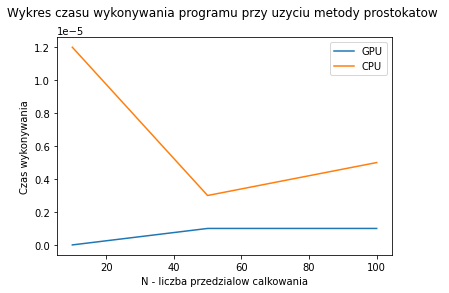

In [18]:
import matplotlib.pyplot as plt

# wartości n
n_values = [10, 50, 100]

# wartości dla GPU
gpu_values = [0.000000, 0.000001, 0.000001]

# wartości dla CPU
cpu_values = [0.000012, 0.000003, 0.000005]


plt.plot(n_values, gpu_values, label="GPU")
plt.plot(n_values, cpu_values, label="CPU")
plt.xlabel("N - liczba przedzialow calkowania")
plt.ylabel("Czas wykonywania")
plt.title("Wykres czasu wykonywania programu przy uzyciu metody prostokatow \n")
plt.legend()
plt.show()

Na wykresie przedstawiono porównanie czasów wykonania programu korzystającego z metody prostokątów, dla różnych wartości liczby przedziałów całkowania (N). Porównano tutaj dwie metody obliczeniowe: korzystającą z GPU oraz CPU. W badaniu zastosowano wartości N odpowiednio: 10, 50 i 100.

Wyniki pokazują, że dla najmniejszej wartości N = 10 różnica między obiema metodami jest nieznaczna. Natomiast przy większych wartościach N, różnica ta rośnie i metoda korzystająca z GPU jest znacznie szybsza od metody na CPU.

Użycie procesora graficznego do obliczeń przyspiesza działanie programu znacznie bardziej przy większych wartościach N.

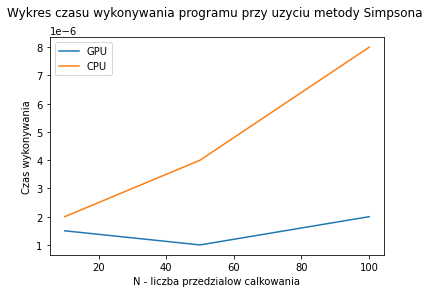

In [22]:
import matplotlib.pyplot as plt

# wartości n
n_values = [10, 50, 100]

# wartości dla GPU
gpu_values = [0.0000015, 0.000001, 0.000002]

# wartości dla CPU
cpu_values = [0.000002, 0.000004, 0.000008]

plt.plot(n_values, gpu_values, label="GPU")
plt.plot(n_values, cpu_values, label="CPU")
plt.xlabel("N - liczba przedzialow calkowania")
plt.ylabel("Czas wykonywania")
plt.title("Wykres czasu wykonywania programu przy uzyciu metody Simpsona \n")
plt.legend()
plt.show()

Na wykresie przedstawiono porównanie czasów wykonania programu korzystającego z metody Simpsona, dla różnych wartości liczby przedziałów całkowania (N). Porównano tutaj dwie metody obliczeniowe: korzystającą z GPU oraz CPU. W badaniu zastosowano wartości N odpowiednio: 10, 50 i 100.

Wyniki pokazują, że dla najmniejszej wartości N = 10 różnica między obiema metodami jest już wieksza a przy większych wartościach N, różnica ta rośnie i metoda korzystająca z GPU jest znacznie szybsza od metody na CPU.

Użycie procesora graficznego do obliczeń przyspiesza działanie programu znacznie bardziej przy większych wartościach N.

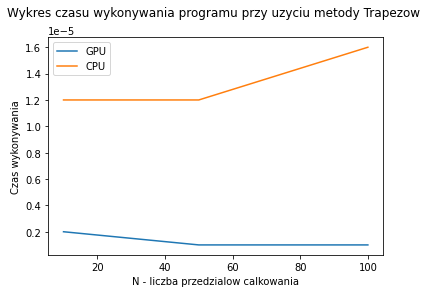

In [20]:
import matplotlib.pyplot as plt

# wartości n
n_values = [10, 50, 100]

# wartości dla GPU
gpu_values = [0.000002, 0.000001, 0.000001]

# wartości dla CPU
cpu_values = [0.000012, 0.000012, 0.000016]

plt.plot(n_values, gpu_values, label="GPU")
plt.plot(n_values, cpu_values, label="CPU")
plt.xlabel("N - liczba przedzialow calkowania")
plt.ylabel("Czas wykonywania")
plt.title("Wykres czasu wykonywania programu przy uzyciu metody Trapezow \n")
plt.legend()
plt.show()


Na wykresie przedstawiono porównanie czasów wykonania programu korzystającego z metody Trapezów, dla różnych wartości liczby przedziałów całkowania (N). Porównano tutaj dwie metody obliczeniowe: korzystającą z GPU oraz CPU. W badaniu zastosowano wartości N odpowiednio: 10, 50 i 100.

Wyniki pokazują, że dla najmniejszej wartości N = 10 różnica między obiema metodami jest już wieksza a przy większych wartościach N, różnica ta rośnie i metoda korzystająca z GPU jest znacznie szybsza od metody na CPU.

Użycie procesora graficznego do obliczeń przyspiesza działanie programu znacznie bardziej przy większych wartościach N.